In [1]:
import os 
import pandas as pd
import numpy as np
from scipy.special import lpmn
from astropy.io import fits
import matplotlib.pylab as plt 
import matplotlib.patches as patches

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 12
save_plots = False
if save_plots:
    os.makedirs('plots', exist_ok=True)

# Kernel Computation Example

In [2]:
import scipy.stats as ss 

In [6]:
normal = ss.norm(1, 0.1)
x = np.linspace(0, 2, 100)

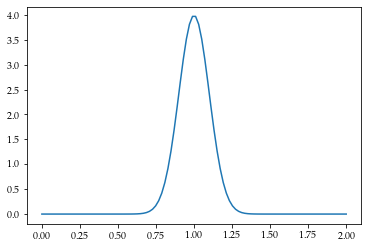

In [7]:
plt.figure()
plt.plot(x, normal.pdf(x))
plt.show()

In [16]:
def compute_kernel(x, px):
    nx = len(x)
    record = list()
    for i in range(1, nx):
        fun = px[i:] * (x[i:] - x[i]) / x[i:]
        integration = np.trapz(fun, x[i:])
        record.append(integration)
    return record
        

In [17]:
kernel = compute_kernel(x, normal.pdf(x))

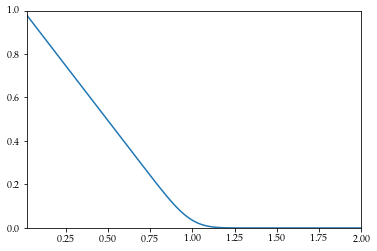

In [22]:
plt.figure()
plt.plot(x[1:], kernel)
plt.xlim(x[1], x[-1])
plt.ylim(0, 1)
plt.show()

# Reference 

[CosmoSiS](https://github.com/joezuntz/cosmosis-standard-library/blob/main/examples/des-y1.ini)

In [2]:
fitsfile = fits.open('data/2pt_NG_mcal_1110.fits')

In [3]:
fitsfile.info()

Filename: data/2pt_NG_mcal_1110.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COVMAT        1 ImageHDU        17   (900, 900)   float64   
  2  xip           1 BinTableHDU     31   200R x 6C   [K, K, K, D, D, D]   
  3  xim           1 BinTableHDU     31   200R x 6C   [K, K, K, D, D, D]   
  4  gammat        1 BinTableHDU     31   400R x 6C   [K, K, K, D, D, D]   
  5  wtheta        1 BinTableHDU     31   100R x 6C   [K, K, K, D, D, D]   
  6  nz_source     1 BinTableHDU     32   400R x 7C   [D, D, D, D, D, D, D]   
  7  nz_lens       1 BinTableHDU     31   400R x 8C   [D, D, D, D, D, D, D, D]   


# Functions

In [4]:
def get_scaled_covariance(covariance: np.ndarray):
    ndata = covariance.shape[0]
    new_cov = np.zeros((ndata, ndata))

    for i in range(ndata):
        for j in range(ndata):
            new_cov[i,j] = covariance[i,j]/np.sqrt(covariance[i,i]*covariance[j,j])
    return new_cov

In [5]:
def plot_data(dataframe, covariance, xlabel, ylabel, nx = 4, factor = 1E4, ylims = (-4, 8), fontsize = 12, fname = 'corr_xi'):
    
    f, ax = plt.subplots(nx, nx, sharex=True, sharey = True, figsize = (10, 10))

    counter = 0

    for i in range(nx):
        for j in range(i+1):

            labz = r'$z_{'+str(i+1)+'}\\times z_{'+str(j+1)+'}$'

            data_plot = dataframe[counter]
            cov_plot = covariance[counter*20:(counter + 1)*20, counter*20: (counter + 1)*20]
            sig_plot = np.sqrt(np.diag(cov_plot))

            xplot = data_plot['ANG']
            yplot = data_plot['VALUE'] * xplot * factor
            yerr = sig_plot * xplot * factor

            ax[i,j].errorbar(xplot, yplot, yerr, fmt='bo', ms=2, lw =1)
            ax[i,j].set_xlabel(xLabel, fontsize=fontsize)
            ax[i,j].set_xlim(1, 300)
            ax[i,j].set_ylim(ylims[0], ylims[1])
            ax[i,j].set_xscale("log")
            ax[i,j].axhline(0, linestyle='--', c = 'k', lw = 0.5)
            ax[i,j].tick_params(axis = 'both', labelsize = fontsize, pad=10)
            ax[i,j].tick_params(axis='both', which='both', length=0)
            ax[i,j].annotate(labz, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

            if j==0 :
                ax[i,j].set_ylabel(yLabel, fontsize=fontsize)

            if j!=i:
                ax[j,i].axis('off')

            counter += 1
    f.subplots_adjust(wspace=0)
    f.subplots_adjust(hspace=0)
    if fname and save_plots:
        plt.savefig(f'plots/{fname}.pdf', bbox_inches='tight')
    plt.show()

In [6]:
def plot_data_omega(dataframe, covariance, xlabel, ylabel, nx = 5, factor = 1, ylims = (-1, 3), fontsize = 12, fname = 'corr_omega'):
    f, ax = plt.subplots(1, nx, sharex=True, sharey = True, figsize = (15, 3))
    
    for counter in range(nx):
        data_plot = dataframe[counter]
        cov_plot = covariance[counter*20:(counter + 1)*20, counter*20: (counter + 1)*20]
        sig_plot = np.sqrt(np.diag(cov_plot))

        labz = r'$z_{'+str(counter+1)+'}$'

        xplot = data_plot['ANG']
        yplot = data_plot['VALUE'] * xplot * factor
        yerr = sig_plot * xplot * factor

        ax[counter].errorbar(xplot, yplot, yerr, fmt='bo', ms=2, lw =1)
        ax[counter].set_xlabel(xLabel, fontsize=fontsize)
        ax[counter].set_xlim(2, 300)
        ax[counter].set_ylim(ylims[0], ylims[1])
        ax[counter].set_xscale("log")
        ax[counter].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[counter].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[counter].tick_params(axis='both', which='both', length=0)
        ax[counter].annotate(labz, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')
        if counter==0 :
            ax[counter].set_ylabel(yLabel, fontsize=fontsize)
    plt.subplots_adjust(wspace=0, hspace=0)
    if fname and save_plots:
        plt.savefig(f'plots/{fname}.pdf', bbox_inches='tight')
    plt.show()

# Covariance Matrix

In [7]:
covariance = fitsfile['COVMAT']

In [8]:
# covariance.header

In [9]:
new_covariance = get_scaled_covariance(covariance.data)
ndata = new_covariance.shape[0]
column_labels = [r'$\xi_{+}$', r'$\xi_{-}$', r'$\gamma_{t}$', r'$\omega$']

In [10]:
# no scaling applied to the covariance matrix
# scaledcov = new_covariance

# here I am scaling the values between -1 and 1. 
cmin = np.amin(new_covariance)
cmax = np.amax(new_covariance)
scaledcov = 2 * (new_covariance - cmin)/(cmax - cmin) - 1

In [11]:
# colormap = plt.cm.gist_heat.reversed()
colormap = plt.cm.Blues# .reversed()

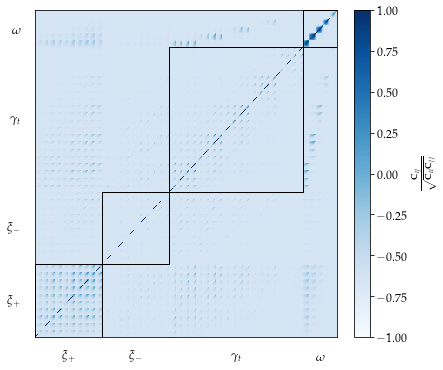

In [28]:
fig, ax = plt.subplots(figsize = (6, 6))

heatmap = ax.pcolor(scaledcov, cmap=colormap, rasterized=True)
cbar = plt.colorbar(heatmap, fraction = 0.05)
cbar.set_label(r'$\frac{\mathbf{C}_{ij}}{\sqrt{\mathbf{C}_{ii}\mathbf{C}_{jj}}}$',size=fontSize)
cbar.ax.tick_params(labelsize=fontSize) 

rect1 = patches.Rectangle((0, 0), 200, 200, linewidth=1, edgecolor='k', facecolor='none')
rect2 = patches.Rectangle((200, 200), 200, 200, linewidth=1, edgecolor='k', facecolor='none')
rect3 = patches.Rectangle((400, 400), 400, 400, linewidth=1, edgecolor='k', facecolor='none')
rect4 = patches.Rectangle((800, 800), 100, 100, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)

ax.set_xticks([100, 300, 600, 850], minor=False)
ax.set_yticks([100, 300, 600, 850], minor=False)

ax.set_xticklabels(column_labels, minor=False, fontsize=fontSize)
ax.set_yticklabels(column_labels, minor=False, fontsize=fontSize)
ax.tick_params(axis=u'both', which=u'both',length=0, pad=15)

if save_plots:
    plt.savefig('plots/des_cov.pdf', bbox_inches='tight')

plt.show()

# $ \xi_{+} $

In [13]:
array = np.vstack(fitsfile['xip'].data)
df_xip = pd.DataFrame(array, columns=fitsfile['xip'].data.names)

# the data and covariance matrices
xip = np.array_split(df_xip, 10)
cov_xip = covariance.data[0:200, 0: 200]
xLabel = r'$\theta\,(\textrm{arcmin})$'
yLabel = r'$\theta \xi_{+} (10^{-4}\,\textrm{arcmin})$'

# binlabel = pd.concat([df_xip['BIN1'], df_xip['BIN2']], axis = 1).drop_duplicates().reset_index(drop=True)
# binlabel = binlabel.astype(int) - 1

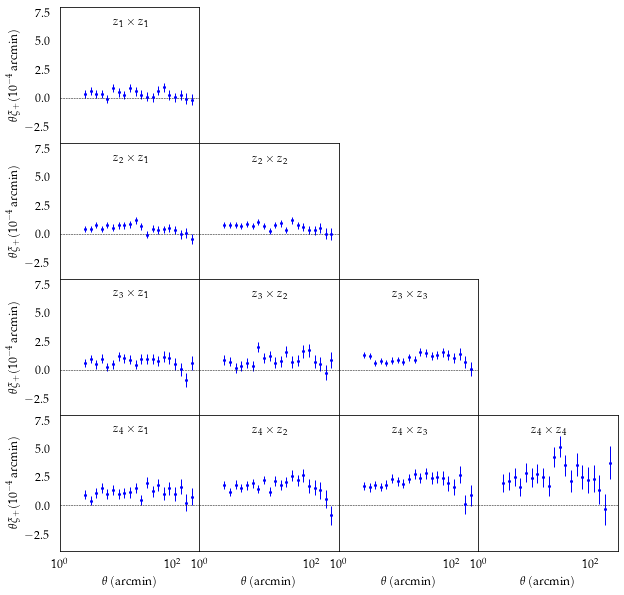

In [14]:
plot_data(xip, cov_xip, xLabel, yLabel, nx = 4, factor = 1E4, ylims = (-4, 8), fontsize=12, fname = 'corr_xip')

# $\xi_{-}$

In [15]:
array = np.vstack(fitsfile['xim'].data)
df_xim = pd.DataFrame(array, columns=fitsfile['xim'].data.names)

# the data and covariance matrices
xim = np.array_split(df_xim, 10)
cov_xim = covariance.data[200:400, 200:400]
xLabel = r'$\theta\,(\textrm{arcmin})$'
yLabel = r'$\theta \xi_{-} (10^{-4}\,\textrm{arcmin})$'

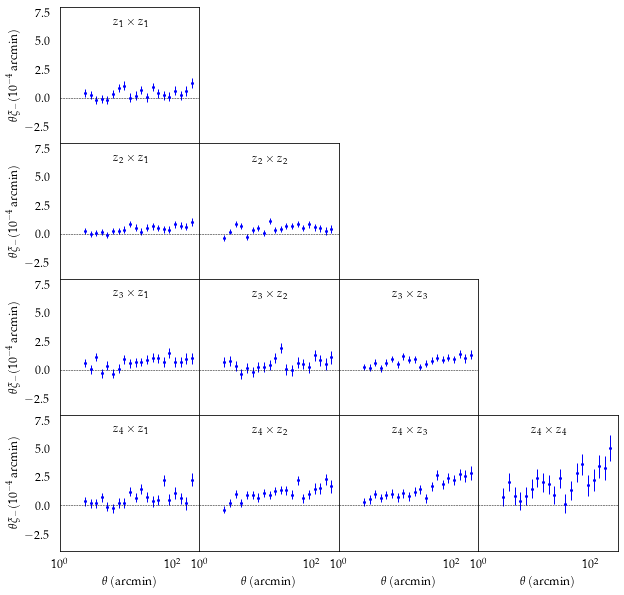

In [16]:
plot_data(xim, cov_xim, xLabel, yLabel, nx = 4, factor=1E4, ylims = (-4, 8), fontsize=12, fname = 'corr_xim')

# $\gamma_{t}$

In [17]:
array = np.vstack(fitsfile['gammat'].data)
df_gammat = pd.DataFrame(array, columns=fitsfile['gammat'].data.names)

# the data and covariance matrices
gammat = np.array_split(df_gammat, 20)
cov_gammat = covariance.data[400:800, 400:800]
xLabel = r'$\theta\,(\textrm{arcmin})$'
yLabel = r'$\theta \gamma_{t} (10^{-4}\,\textrm{arcmin})$'

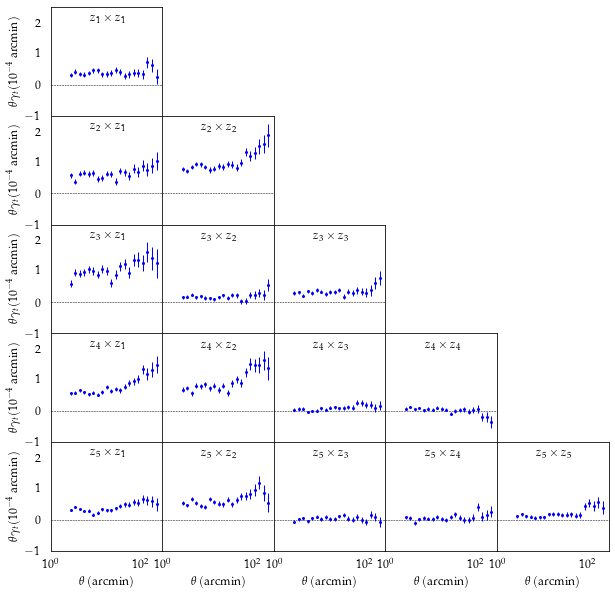

In [18]:
plot_data(gammat, cov_gammat, xLabel, yLabel, nx = 5, factor = 1E2, ylims = (-1, 2.5), fontsize=12, fname = 'corr_gammat')

# $\omega$

In [19]:
array = np.vstack(fitsfile['wtheta'].data)
df_wtheta = pd.DataFrame(array, columns=fitsfile['wtheta'].data.names)

# the data and covariance matrices
wtheta = np.array_split(df_wtheta, 5)
cov_wtheta = covariance.data[800:, 800:]

In [20]:
xLabel = r'$\theta\,(\textrm{arcmin})$'
yLabel = r'$\theta \omega\,(10^{-4}\,\textrm{arcmin})$'

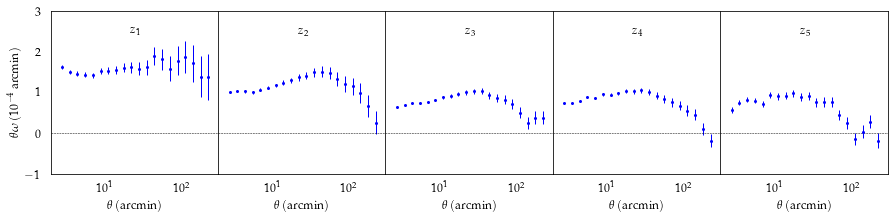

In [21]:
plot_data_omega(wtheta, cov_wtheta, xLabel, yLabel, fname = 'corr_omega')

# $n_{\textrm{source}}(z)$ 

In [22]:
df_source = pd.DataFrame(fitsfile['nz_source'].data)

In [23]:
df_lens = pd.DataFrame(fitsfile['nz_lens'].data)

In [24]:
df_source.head()

,Z_LOW,Z_MID,Z_HIGH,BIN1,BIN2,BIN3,BIN4
0,0.0001,0.0051,0.0101,0.010654,0.003370,0.003765,0.006841
1,0.0101,0.0151,0.0201,0.031892,0.011528,0.008802,0.019403
2,0.0201,0.0251,0.0301,0.053965,0.020341,0.013476,0.029524
3,0.0301,0.0351,0.0401,0.082612,0.031296,0.018851,0.041985
4,0.0401,0.0451,0.0501,0.114755,0.041747,0.025174,0.055386


In [25]:
df_lens.head()

,Z_LOW,Z_MID,Z_HIGH,BIN1,BIN2,BIN3,BIN4,BIN5
0,0.0001,0.0051,0.0101,0.0,0.0,0.0,0.0,0.0
1,0.0101,0.0151,0.0201,0.0,0.0,0.0,0.0,0.0
2,0.0201,0.0251,0.0301,0.0,0.0,0.0,0.0,0.0
3,0.0301,0.0351,0.0401,0.0,0.0,0.0,0.0,0.0
4,0.0401,0.0451,0.0501,0.0,0.0,0.0,0.0,0.0


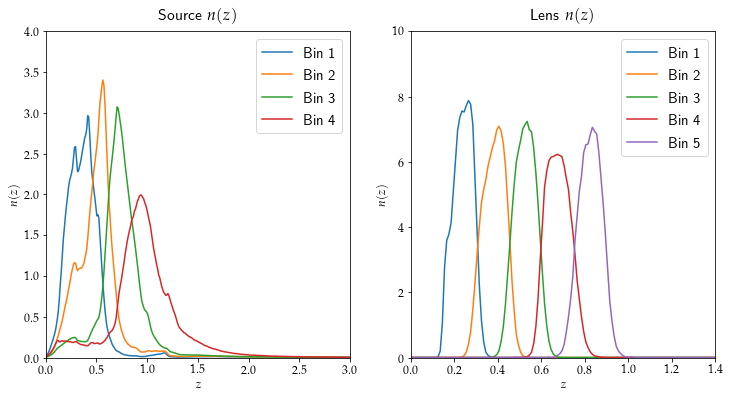

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Source $n(z)$', fontsize=fontSize+4, y = 1.02)
plt.plot(df_source['Z_MID'], df_source['BIN1'], label = 'Bin 1')
plt.plot(df_source['Z_MID'], df_source['BIN2'], label = 'Bin 2')
plt.plot(df_source['Z_MID'], df_source['BIN3'], label = 'Bin 3')
plt.plot(df_source['Z_MID'], df_source['BIN4'], label = 'Bin 4')
plt.ylabel(r'$n(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 4.0)
plt.xlim(0.0, 3.0)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.subplot(122)
plt.title('Lens $n(z)$', fontsize=fontSize+4, y = 1.02)
plt.plot(df_lens['Z_MID'], df_lens['BIN1'], label = 'Bin 1')
plt.plot(df_lens['Z_MID'], df_lens['BIN2'], label = 'Bin 2')
plt.plot(df_lens['Z_MID'], df_lens['BIN3'], label = 'Bin 3')
plt.plot(df_lens['Z_MID'], df_lens['BIN4'], label = 'Bin 4')
plt.plot(df_lens['Z_MID'], df_lens['BIN5'], label = 'Bin 5')
plt.ylabel(r'$n(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 10)
plt.xlim(0.0, 1.4)
plt.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15}, ncol = 1)
plt.show()

# Legendre Polynomial

In cosmology:
$$
P^{m}_{l}(x)
$$

In scipy:

$$
P^{m}_{n}(z)
$$

The first few associated Legendre polynomials are:
<img src="images/associated-legendre.png" alt="Drawing" style="width: 200px;"/>

In [27]:
lpmn(m=2, n=6, z=0)[0]

array([[ 1.    ,  0.    , -0.5   , -0.    ,  0.375 ,  0.    , -0.3125],
       [ 0.    , -1.    , -0.    ,  1.5   ,  0.    , -1.875 , -0.    ],
       [ 0.    ,  0.    ,  3.    ,  0.    , -7.5   , -0.    , 13.125 ]])